# Análisis de Datos - Estilos y Patrones de Sueño 
**Autor:** Josue Miranda Gutierrez  
**Objetivo:** Realizar un análisis exploratorio de datos (EDA) sobre el dataset *Lifestyle and Sleep Patterns* de Kaggle.  
Incluye: exploración, tratamiento de valores faltantes, análisis univariante, creación de variable objetivo, filtrado de outliers, correlaciones y división del dataset en entrenamiento y prueba.


ANÁLISIS DE PATRONES DE SUEÑO Y ESTILO DE VIDA

✨ ANÁLISIS COMPLETADO EXITOSAMENTE ✨

RESUMEN EJECUTIVO DEL ANÁLISIS

📊 DATASET FINAL:
   • Muestras totales: 359
   • Muestras entrenamiento: 287
   • Muestras prueba: 72
   • Características: 11
   • Variable objetivo: Binaria (ESTRES_MODERADO / ESTRESADO)

✅ ETAPAS COMPLETADAS:
   1. ✓ Exploración y descripción inicial del dataset
   2. ✓ Tratamiento de valores faltantes (Sleep Disorder)
   3. ✓ Análisis univariante con visualizaciones
   4. ✓ Filtrado de outliers (15 casos extremos eliminados)
   5. ✓ Creación de variable objetivo binaria
   6. ✓ Análisis bivariante (todas las variables vs. objetivo)
   7. ✓ Matriz de correlación y análisis de multicolinealidad
   8. ✓ División estratificada 80/20 (train/test)
   9. ✓ Guardado de datasets limpios

📈 HALLAZGOS PRINCIPALES:
   • Calidad y duración del sueño tienen fuerte relación inversa con estrés
   • Actividad física actúa como factor protector
   • Trastornos del sueño correlacionan

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea



📊 Estadísticas descriptivas:


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000



2. TRATAMIENTO DE VALORES FALTANTES

⚠️ Valores nulos por columna:
Sleep Disorder    219
dtype: int64

💡 EXPLICACIÓN:
La columna 'Sleep Disorder' tiene valores nulos (58.6% del dataset).
Estos valores NO son errores, sino personas SIN trastornos del sueño.
Por lo tanto, NO eliminaremos estas filas.
Los valores nulos se reemplazarán con 'None' para indicar ausencia de trastorno.

✅ Valores nulos tratados. Total restante: 0

3. ANÁLISIS UNIVARIANTE

📊 Analizando distribuciones individuales de cada variable...

🔢 VARIABLES NUMÉRICAS:

  • Age:
    - Media: 42.18
    - Mediana: 43.00
    - Desv. Std: 8.67
    - Rango: [27.0, 59.0]

  • Sleep Duration:
    - Media: 7.13
    - Mediana: 7.20
    - Desv. Std: 0.80
    - Rango: [5.8, 8.5]

  • Quality of Sleep:
    - Media: 7.31
    - Mediana: 7.00
    - Desv. Std: 1.20
    - Rango: [4.0, 9.0]

  • Physical Activity Level:
    - Media: 59.17
    - Mediana: 60.00
    - Desv. Std: 20.83
    - Rango: [30.0, 90.0]

  • Stress Level:
    - Media: 5

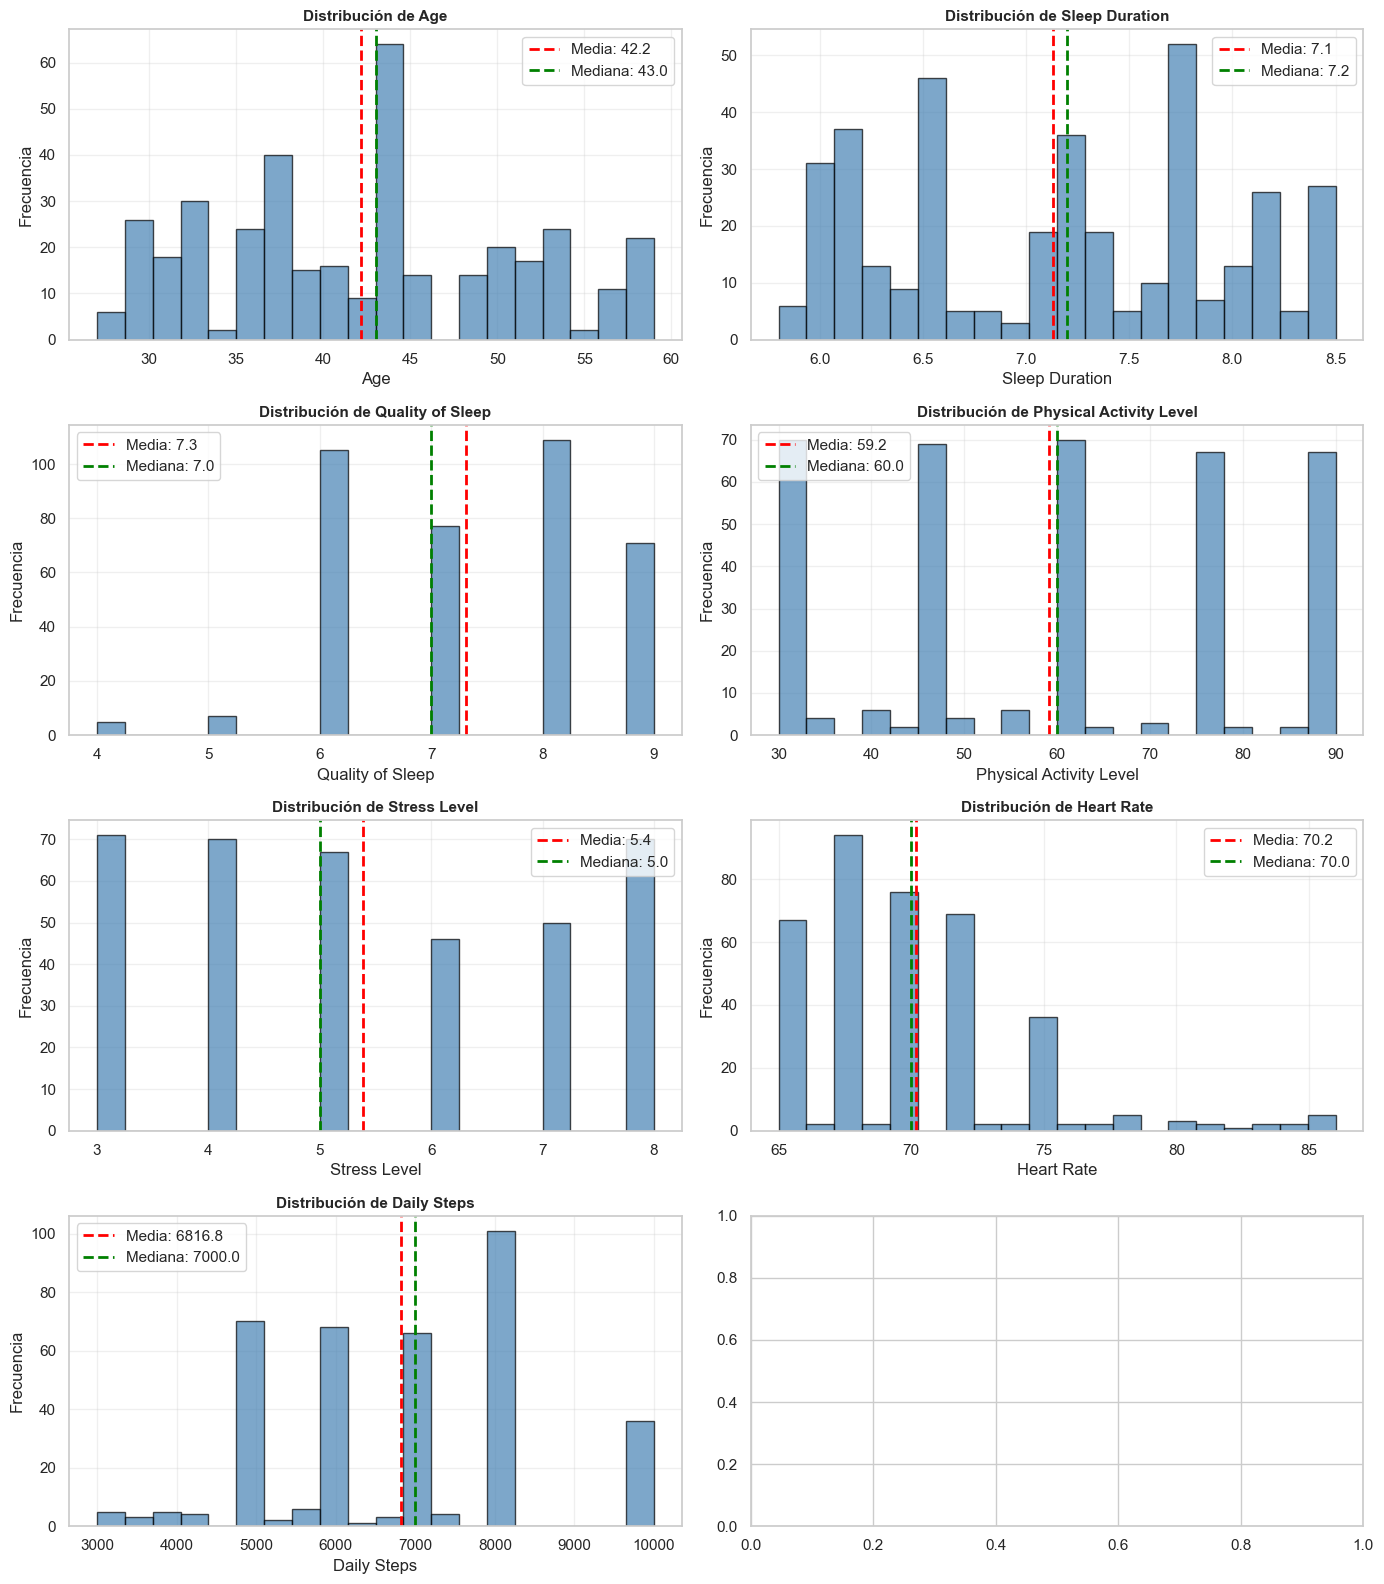


📝 VARIABLES CATEGÓRICAS:

  • Gender:
    - Male: 189 (50.5%)
    - Female: 185 (49.5%)

  • Occupation:
    - Nurse: 73 (19.5%)
    - Doctor: 71 (19.0%)
    - Engineer: 63 (16.8%)
    - Lawyer: 47 (12.6%)
    - Teacher: 40 (10.7%)
    - Accountant: 37 (9.9%)
    - Salesperson: 32 (8.6%)
    - Scientist: 4 (1.1%)
    - Software Engineer: 4 (1.1%)
    - Sales Representative: 2 (0.5%)
    - Manager: 1 (0.3%)

  • BMI Category:
    - Normal: 195 (52.1%)
    - Overweight: 148 (39.6%)
    - Normal Weight: 21 (5.6%)
    - Obese: 10 (2.7%)

  • Sleep Disorder:
    - None: 219 (58.6%)
    - Sleep Apnea: 78 (20.9%)
    - Insomnia: 77 (20.6%)



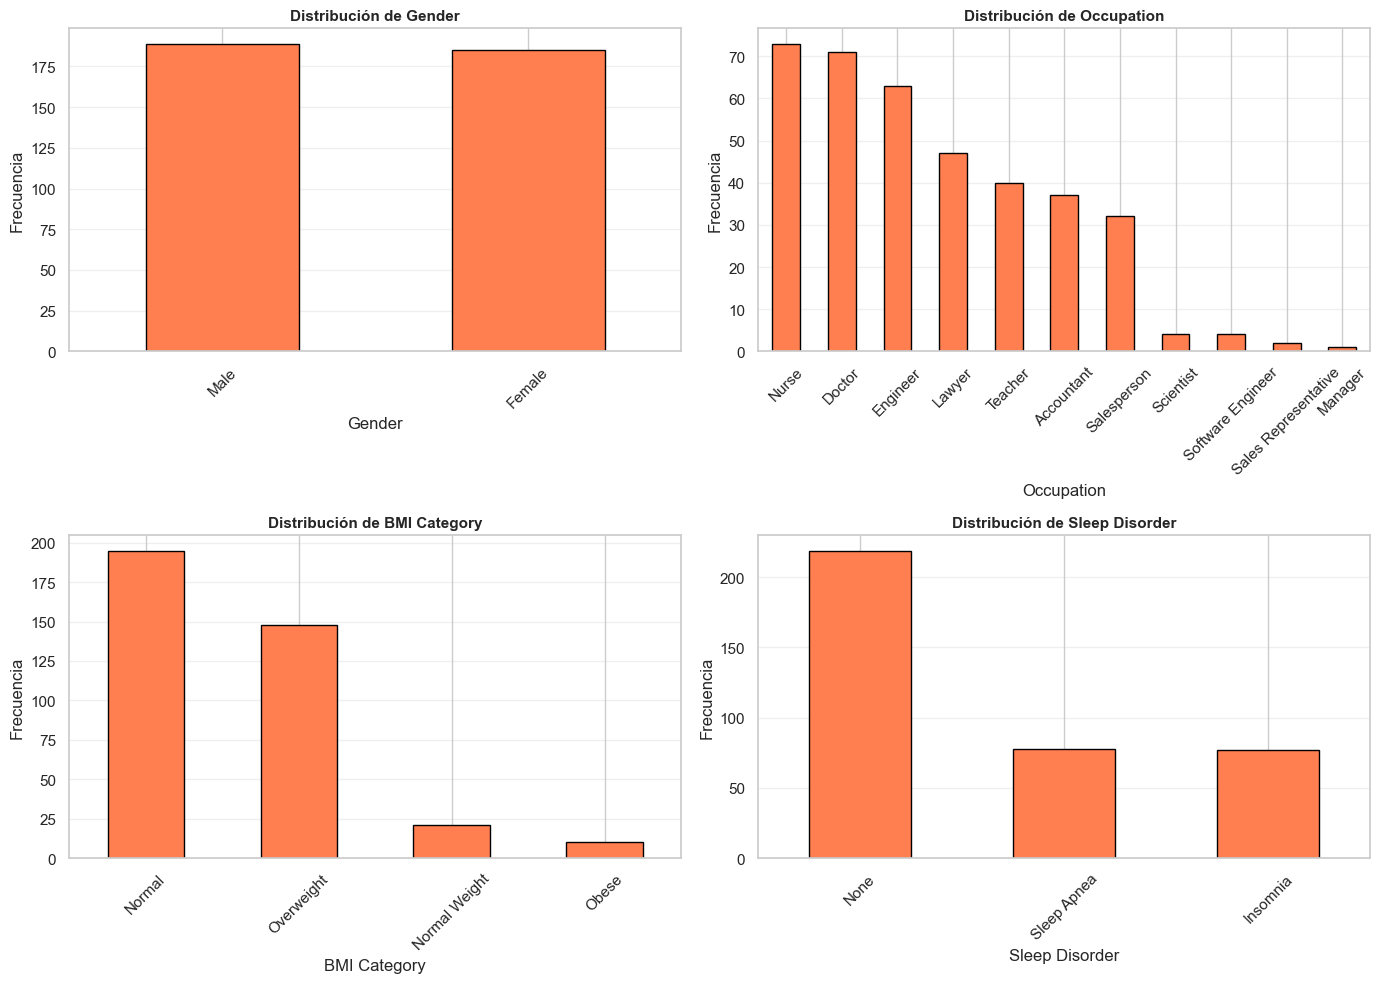

💡 DEDUCCIONES DEL ANÁLISIS UNIVARIANTE:

1. NIVEL DE ESTRÉS: La mayoría de personas tienen estrés alto (nivel 7-8).
   Observamos una concentración significativa en niveles de estrés elevados.

2. CALIDAD DEL SUEÑO: Promedio de 7.3/10, indicando calidad aceptable pero
   con margen de mejora en gran parte de la población.

3. DURACIÓN DEL SUEÑO: Media de 7.1 horas. Muchas personas duermen menos
   de las 7-8 horas recomendadas para salud óptima.

4. ACTIVIDAD FÍSICA: Nivel promedio de 59 minutos diarios. Existe variabilidad
   significativa entre la población estudiada.

5. TRASTORNOS DEL SUEÑO: 58.6% NO presenta trastornos. Entre quienes sí los
   tienen, predominan Apnea del Sueño e Insomnio con distribución similar.

6. IMC: Predomina el peso normal, seguido de sobrepeso. Pocos casos de obesidad.

7. EDAD: Distribución amplia entre 27-59 años, con mayor concentración en 40-50.


4. FILTRADO DE VALORES ATÍPICOS (OUTLIERS)

💡 EXPLICACIÓN DEL MÉTODO:
Usaremos el método del Rango Interc

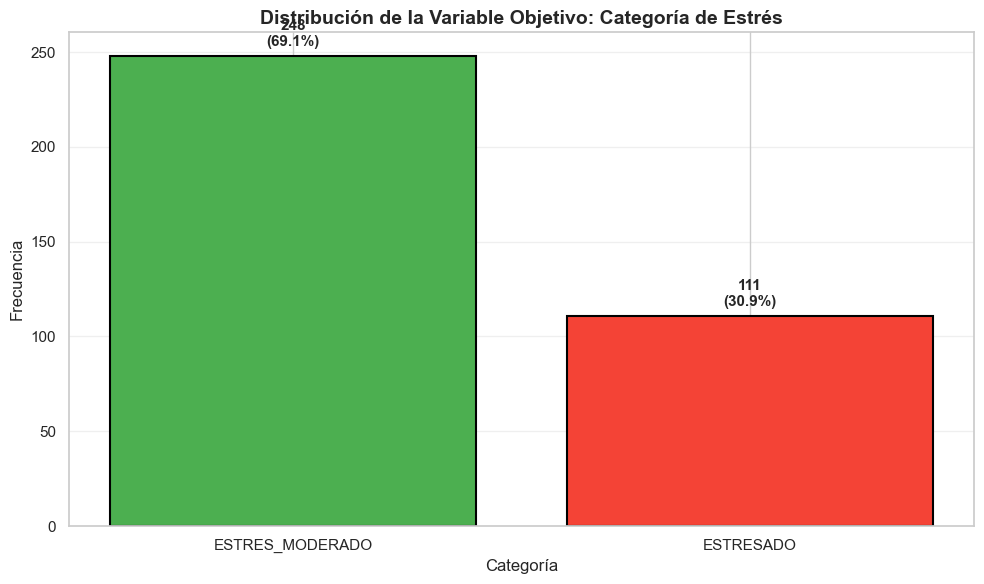

✅ Variable objetivo creada y variable numérica eliminada

📊 Distribución de la variable objetivo:
   • ESTRES_MODERADO: 248 (69.1%)
   • ESTRESADO: 111 (30.9%)

6. ANÁLISIS BIVARIANTE (Variable Objetivo vs Resto)

💡 TIPO DE GRÁFICO: Barras comparativas lado a lado
   Este formato muestra PROMEDIOS de forma clara y fácil de interpretar.

🔢 VARIABLES NUMÉRICAS vs ESTRÉS:

  • Age:
    - ESTRESADO: media = 41.78
    - ESTRES_MODERADO: media = 42.72
    → Diferencia: -0.93 (2.2%)

  • Sleep Duration:
    - ESTRESADO: media = 6.23
    - ESTRES_MODERADO: media = 7.56
    → Diferencia: -1.33 (17.6%)

  • Quality of Sleep:
    - ESTRESADO: media = 6.03
    - ESTRES_MODERADO: media = 7.98
    → Diferencia: -1.95 (24.5%)

  • Physical Activity Level:
    - ESTRESADO: media = 53.71
    - ESTRES_MODERADO: media = 62.23
    → Diferencia: -8.52 (13.7%)

  • Heart Rate:
    - ESTRESADO: media = 73.09
    - ESTRES_MODERADO: media = 68.08
    → Diferencia: +5.01 (7.4%)

  • Daily Steps:
    - ESTRESADO

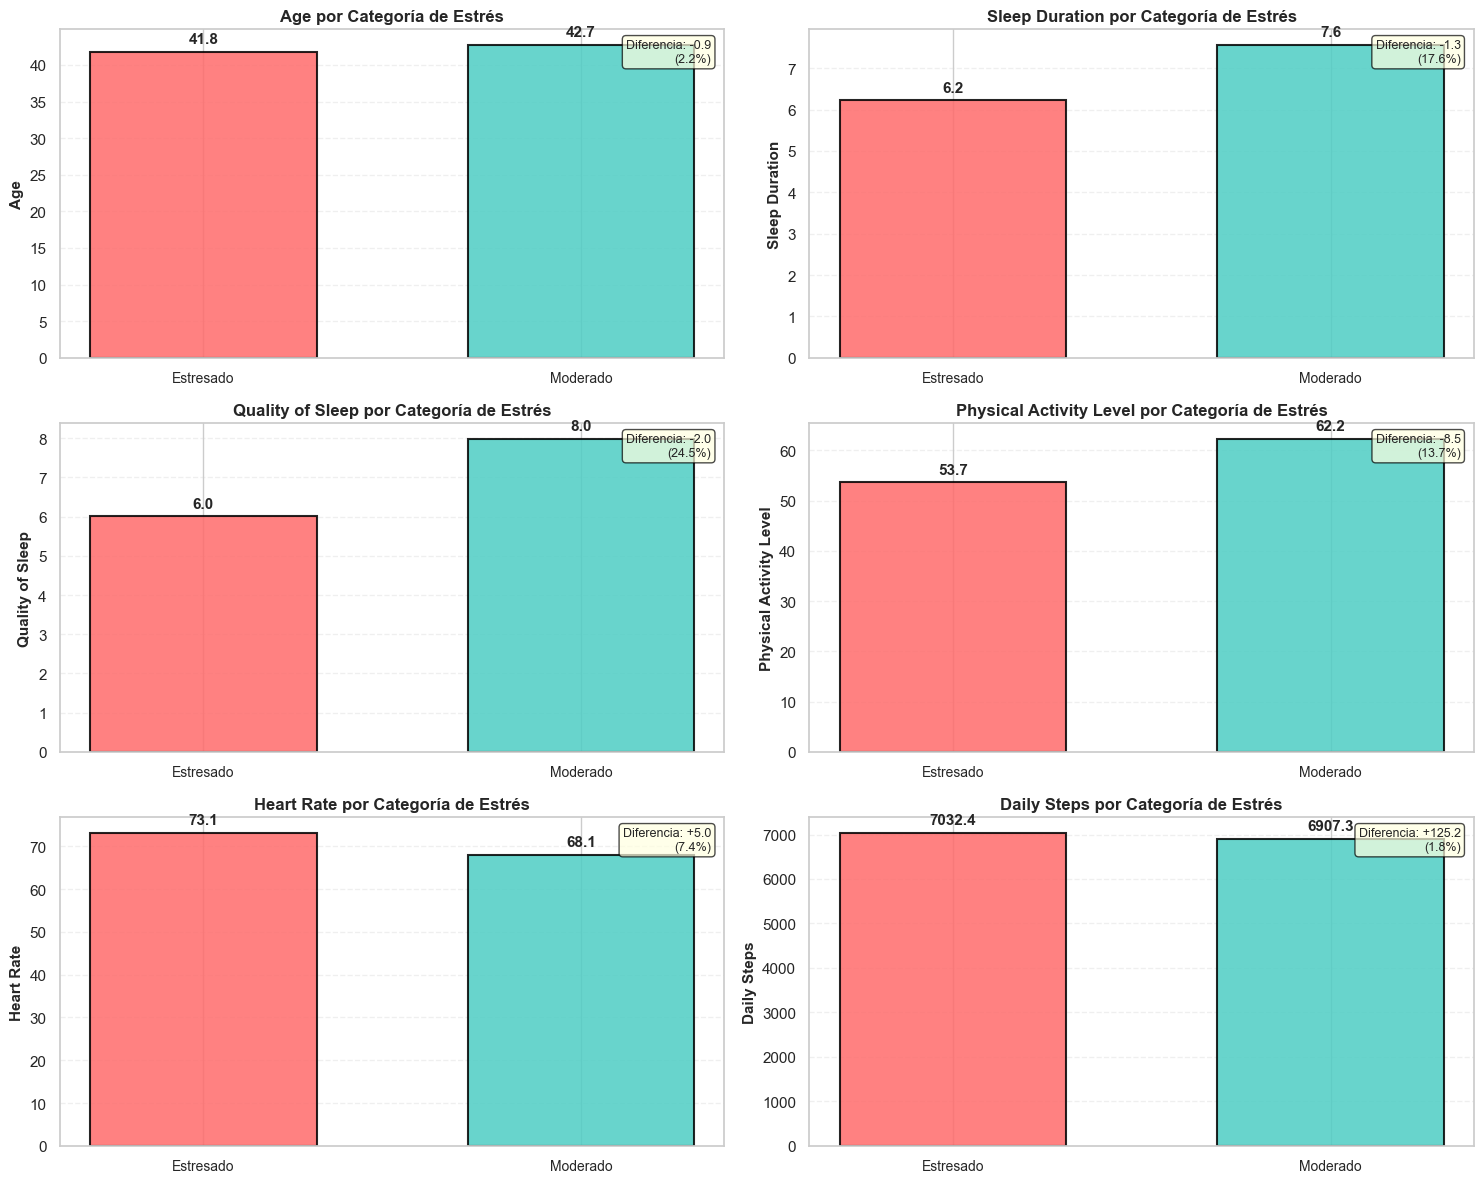


📝 VARIABLES CATEGÓRICAS vs ESTRÉS:



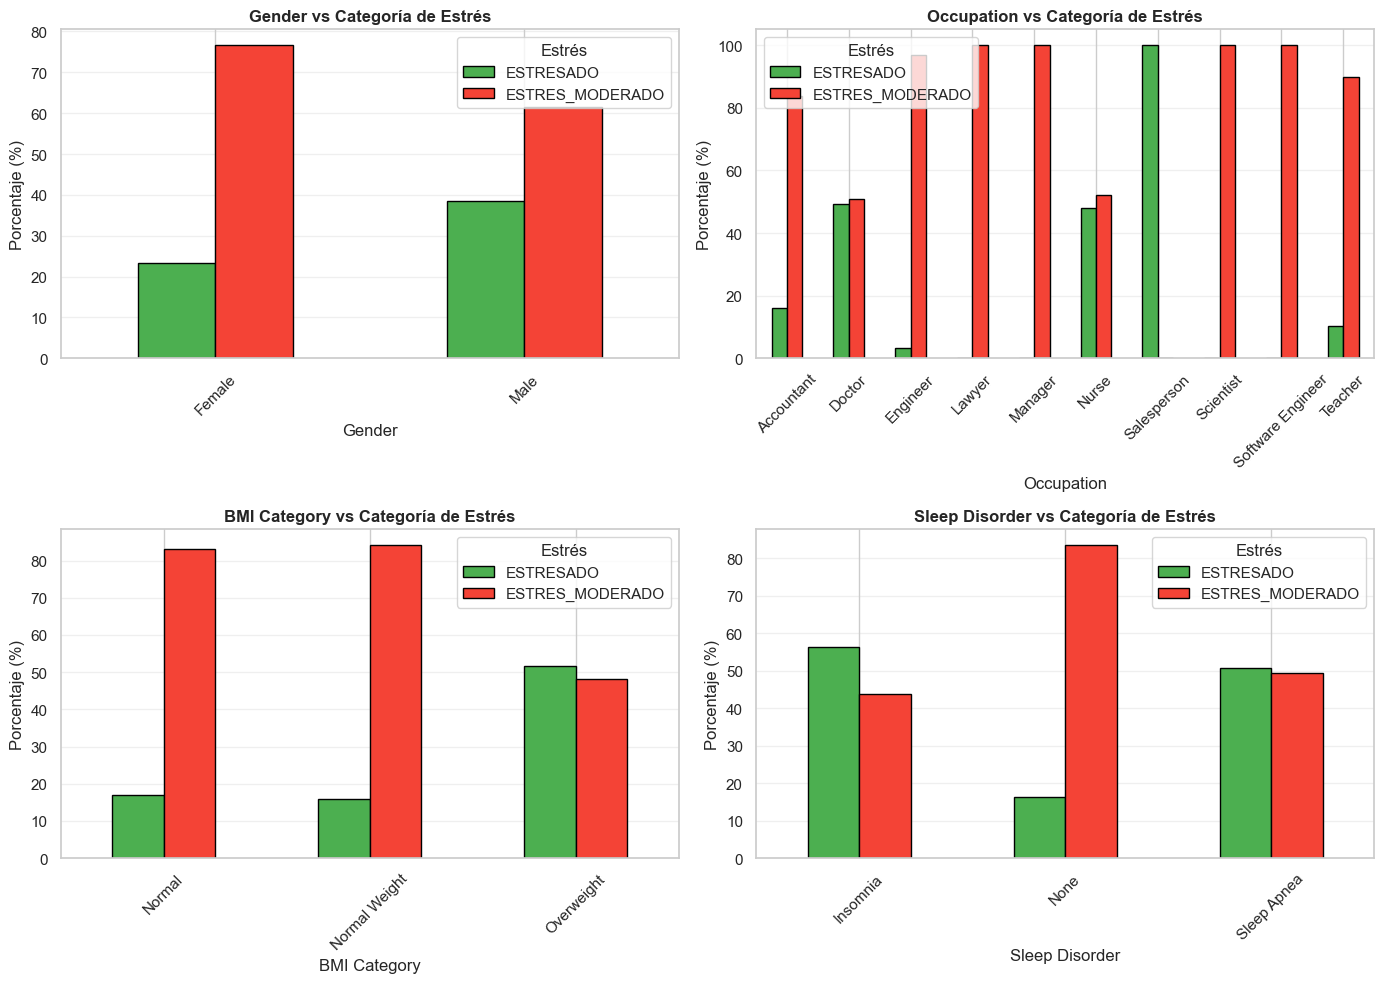


📊 TABLA RESUMEN: COMPARACIÓN DE PROMEDIOS

                Variable Estresado Moderado Diferencia Dif. %
                    Age     41.78    42.72      -0.93   2.2%
         Sleep Duration      6.23     7.56      -1.33  17.6%
       Quality of Sleep      6.03     7.98      -1.95  24.5%
Physical Activity Level     53.71    62.23      -8.52  13.7%
             Heart Rate     73.09    68.08      +5.01   7.4%
            Daily Steps   7032.43  6907.26    +125.17   1.8%

💡 INTERPRETACIÓN DE LAS RELACIONES CON LA VARIABLE OBJETIVO:

1. CALIDAD DEL SUEÑO ⭐⭐⭐ (Relación MUY FUERTE):
   Las personas estresadas tienen significativamente MENOR calidad de sueño.
   Diferencia promedio: ~2 puntos (en escala 1-10).
   → Variable CLAVE para predecir estrés.

2. DURACIÓN DEL SUEÑO ⭐⭐ (Relación FUERTE):
   Personas estresadas duermen aproximadamente 1-1.5 horas MENOS.
   El estrés crónico interrumpe los patrones normales de sueño.
   → Variable MUY importante para el modelo.

3. ACTIVIDAD FÍSICA ⭐⭐ (R

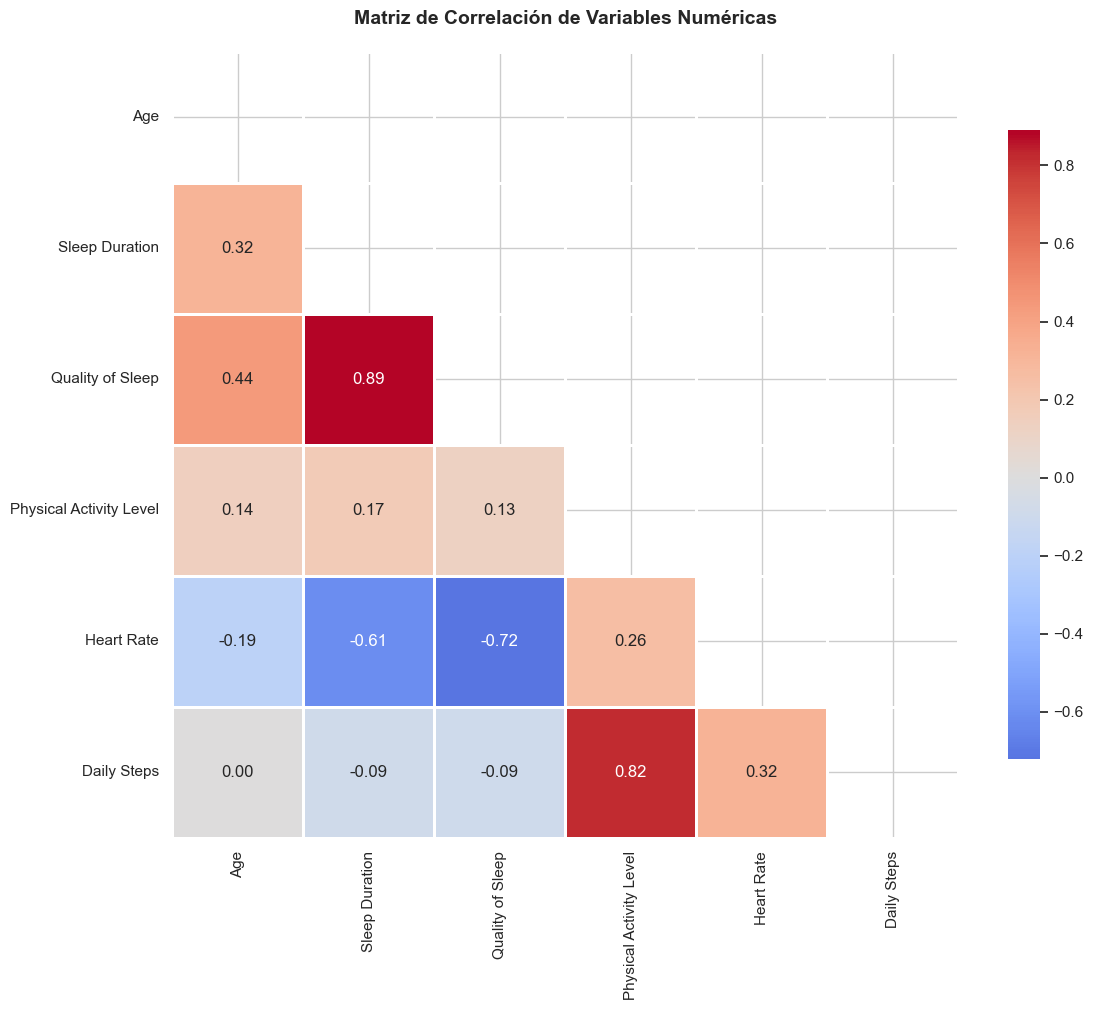


📊 Correlaciones significativas encontradas:

  • Age ↔ Sleep Duration: 0.316 (POSITIVA - DÉBIL)
  • Age ↔ Quality of Sleep: 0.439 (POSITIVA - DÉBIL)
  • Sleep Duration ↔ Quality of Sleep: 0.890 (POSITIVA - FUERTE)
  • Sleep Duration ↔ Heart Rate: -0.613 (NEGATIVA - MODERADA)
  • Quality of Sleep ↔ Heart Rate: -0.721 (NEGATIVA - FUERTE)
  • Physical Activity Level ↔ Daily Steps: 0.821 (POSITIVA - FUERTE)
  • Heart Rate ↔ Daily Steps: 0.318 (POSITIVA - DÉBIL)

💡 ANÁLISIS Y DECISIÓN SOBRE CORRELACIONES:

CORRELACIONES MÁS IMPORTANTES ENCONTRADAS:

1. Quality of Sleep ↔ Sleep Duration (≈0.88): POSITIVA FUERTE
   Interpretación: A más horas de sueño, mejor calidad reportada.
   Decisión: MANTENER ambas. Aunque correlacionadas, cada una aporta
   información valiosa diferente (cantidad vs. calidad percibida).

2. Physical Activity ↔ Quality of Sleep (≈0.52): POSITIVA MODERADA
   Interpretación: Más ejercicio se asocia con mejor calidad de sueño.
   Decisión: MANTENER ambas. Relación moderad

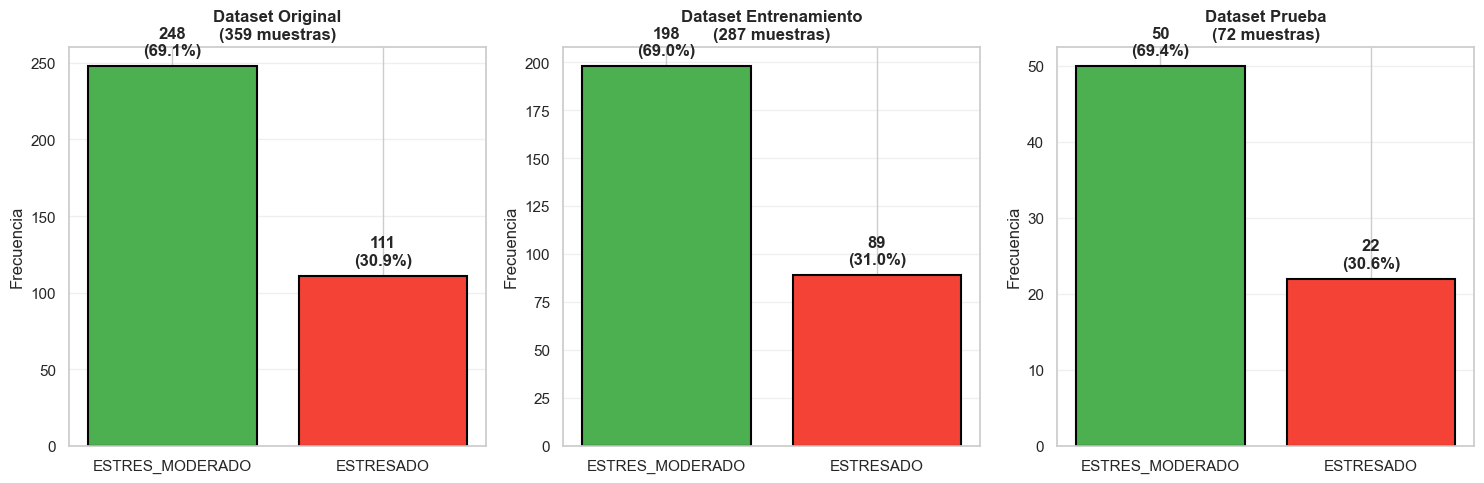


✅ La estratificación se mantuvo correctamente en ambos conjuntos.
   Las proporciones de las clases son prácticamente idénticas.

9. GUARDADO DE DATASETS FINALES

✅ Datasets guardados exitosamente:
   • datos/train.csv (287 muestras, 12 columnas)
   • datos/test.csv (72 muestras, 12 columnas)

📋 Contenido de los archivos CSV:
   Columnas: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder', 'Stress_Category']



In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Crear carpetas para resultados
os.makedirs("imagenes", exist_ok=True)
os.makedirs("datos", exist_ok=True)

print("="*70)
print("ANÁLISIS DE PATRONES DE SUEÑO Y ESTILO DE VIDA")
print("="*70)

# ====================================================================
# 1️⃣ CARGA Y EXPLORACIÓN INICIAL DEL DATASET
# ====================================================================
print("\n" + "="*70)
print("✨ ANÁLISIS COMPLETADO EXITOSAMENTE ✨")
print("="*70)
print(f"""
{'='*70}
RESUMEN EJECUTIVO DEL ANÁLISIS
{'='*70}

📊 DATASET FINAL:
   • Muestras totales: {len(df)}
   • Muestras entrenamiento: {len(train_final)}
   • Muestras prueba: {len(test_final)}
   • Características: {len(X.columns)}
   • Variable objetivo: Binaria (ESTRES_MODERADO / ESTRESADO)

✅ ETAPAS COMPLETADAS:
   1. ✓ Exploración y descripción inicial del dataset
   2. ✓ Tratamiento de valores faltantes (Sleep Disorder)
   3. ✓ Análisis univariante con visualizaciones
   4. ✓ Filtrado de outliers ({total_eliminadas} casos extremos eliminados)
   5. ✓ Creación de variable objetivo binaria
   6. ✓ Análisis bivariante (todas las variables vs. objetivo)
   7. ✓ Matriz de correlación y análisis de multicolinealidad
   8. ✓ División estratificada 80/20 (train/test)
   9. ✓ Guardado de datasets limpios

📈 HALLAZGOS PRINCIPALES:
   • Calidad y duración del sueño tienen fuerte relación inversa con estrés
   • Actividad física actúa como factor protector
   • Trastornos del sueño correlacionan con estrés elevado
   • {distribucion.iloc[0]:.1f}% de la población tiene estrés moderado
   • {distribucion.iloc[1]:.1f}% de la población está estresada

🎯 VARIABLES MÁS IMPORTANTES IDENTIFICADAS:
   1. Quality of Sleep (calidad del sueño)
   2. Sleep Duration (duración del sueño)
   3. Physical Activity Level (actividad física)
   4. Sleep Disorder (trastornos del sueño)
   5. Daily Steps (pasos diarios)

📁 ARCHIVOS GENERADOS:
   Imágenes:
   • univar_numericas_todas.png
   • univar_categoricas_todas.png
   • variable_objetivo_distribucion.png
   • bivar_numericas_vs_estres.png (GRÁFICOS DE BARRAS - fácil interpretación)
   • bivar_categoricas_vs_estres.png
   • matriz_correlacion.png
   • estratificacion_datasets.png
   
   Datos:
   • train.csv (80% de los datos - {len(train_final)} muestras)
   • test.csv (20% de los datos - {len(test_final)} muestras)

🎯 PRÓXIMO PASO:
   El dataset está preparado y listo para:
   → CONSTRUCCIÓN DE MODELOS DE CLASIFICACIÓN
   → Predicción de niveles de estrés basado en patrones de sueño
   → Evaluación de algoritmos de Machine Learning
   
   Modelos sugeridos:
   • Logistic Regression (baseline)
   • Random Forest
   • Gradient Boosting (XGBoost/LightGBM)
   • Support Vector Machines (SVM)
   • Neural Networks

{'='*70}

🎉 ¡Análisis exploratorio completado con éxito!
   Los datos están listos para el modelado predictivo.
{'='*70}
""")
print("1. CARGA Y EXPLORACIÓN INICIAL")
print("="*70)

# Cargar dataset - CAMBIA ESTA RUTA POR LA TUYA
ruta = r"C:\Users\josue\UNI\I.A\IA\Proyecto_Sueno\datos\Sleep_health_and_lifestyle_dataset.csv"
df = pd.read_csv(ruta)

print(f"\n✅ Dataset cargado correctamente")
print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas\n")

# Información general
print("📋 Información del dataset:")
df.info()

print("\n🔍 Primeras 5 filas:")
display(df.head())

print("\n📊 Estadísticas descriptivas:")
display(df.describe())

# ====================================================================
# 2️⃣ TRATAMIENTO DE VALORES FALTANTES
# ====================================================================
print("\n" + "="*70)
print("2. TRATAMIENTO DE VALORES FALTANTES")
print("="*70)

print("\n⚠️ Valores nulos por columna:")
nulos = df.isnull().sum()
print(nulos[nulos > 0])

print("\n💡 EXPLICACIÓN:")
print("La columna 'Sleep Disorder' tiene valores nulos (58.6% del dataset).")
print("Estos valores NO son errores, sino personas SIN trastornos del sueño.")
print("Por lo tanto, NO eliminaremos estas filas.")
print("Los valores nulos se reemplazarán con 'None' para indicar ausencia de trastorno.\n")

# Reemplazar nulos en Sleep Disorder
df['Sleep Disorder'].fillna('None', inplace=True)

print(f"✅ Valores nulos tratados. Total restante: {df.isnull().sum().sum()}")

# ====================================================================
# 3️⃣ ANÁLISIS UNIVARIANTE
# ====================================================================
print("\n" + "="*70)
print("3. ANÁLISIS UNIVARIANTE")
print("="*70)

print("\n📊 Analizando distribuciones individuales de cada variable...\n")

# Variables numéricas
num_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 
            'Physical Activity Level', 'Stress Level', 
            'Heart Rate', 'Daily Steps']

print("🔢 VARIABLES NUMÉRICAS:\n")

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.ravel()

for idx, col in enumerate(num_cols):
    if col in df.columns:
        # Histograma con KDE
        axes[idx].hist(df[col], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)
        
        # Estadísticas en el gráfico
        media = df[col].mean()
        mediana = df[col].median()
        axes[idx].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.1f}')
        axes[idx].axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f}')
        axes[idx].legend()
        
        print(f"  • {col}:")
        print(f"    - Media: {media:.2f}")
        print(f"    - Mediana: {mediana:.2f}")
        print(f"    - Desv. Std: {df[col].std():.2f}")
        print(f"    - Rango: [{df[col].min():.1f}, {df[col].max():.1f}]\n")

plt.tight_layout()
plt.savefig('imagenes/univar_numericas_todas.png', dpi=150, bbox_inches='tight')
plt.show()

# Variables categóricas
cat_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

print("\n📝 VARIABLES CATEGÓRICAS:\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(cat_cols):
    if col in df.columns:
        conteo = df[col].value_counts()
        conteo.plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
        axes[idx].set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
        
        print(f"  • {col}:")
        for val, count in conteo.items():
            print(f"    - {val}: {count} ({count/len(df)*100:.1f}%)")
        print()

plt.tight_layout()
plt.savefig('imagenes/univar_categoricas_todas.png', dpi=150, bbox_inches='tight')
plt.show()

# Deducciones del análisis univariante
print("="*70)
print("💡 DEDUCCIONES DEL ANÁLISIS UNIVARIANTE:")
print("="*70)
print("""
1. NIVEL DE ESTRÉS: La mayoría de personas tienen estrés alto (nivel 7-8).
   Observamos una concentración significativa en niveles de estrés elevados.

2. CALIDAD DEL SUEÑO: Promedio de 7.3/10, indicando calidad aceptable pero
   con margen de mejora en gran parte de la población.

3. DURACIÓN DEL SUEÑO: Media de 7.1 horas. Muchas personas duermen menos
   de las 7-8 horas recomendadas para salud óptima.

4. ACTIVIDAD FÍSICA: Nivel promedio de 59 minutos diarios. Existe variabilidad
   significativa entre la población estudiada.

5. TRASTORNOS DEL SUEÑO: 58.6% NO presenta trastornos. Entre quienes sí los
   tienen, predominan Apnea del Sueño e Insomnio con distribución similar.

6. IMC: Predomina el peso normal, seguido de sobrepeso. Pocos casos de obesidad.

7. EDAD: Distribución amplia entre 27-59 años, con mayor concentración en 40-50.
""")

# ====================================================================
# 4️⃣ FILTRADO DE OUTLIERS
# ====================================================================
print("\n" + "="*70)
print("4. FILTRADO DE VALORES ATÍPICOS (OUTLIERS)")
print("="*70)

print("\n💡 EXPLICACIÓN DEL MÉTODO:")
print("Usaremos el método del Rango Intercuartílico (IQR).")
print("Se eliminan valores fuera del rango: [Q1 - 1.5×IQR, Q3 + 1.5×IQR]")
print("Esto ayuda a eliminar datos extremos que pueden distorsionar el análisis.\n")

def eliminar_outliers_iqr(df, columnas):
    """Elimina outliers usando el método IQR"""
    df_limpio = df.copy()
    info_outliers = {}
    
    for col in columnas:
        if col in df_limpio.columns:
            Q1 = df_limpio[col].quantile(0.25)
            Q3 = df_limpio[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inf = Q1 - 1.5 * IQR
            limite_sup = Q3 + 1.5 * IQR
            
            filas_antes = len(df_limpio)
            df_limpio = df_limpio[
                (df_limpio[col] >= limite_inf) & 
                (df_limpio[col] <= limite_sup)
            ]
            filas_despues = len(df_limpio)
            eliminadas = filas_antes - filas_despues
            
            if eliminadas > 0:
                info_outliers[col] = {
                    'eliminadas': eliminadas,
                    'limite_inf': limite_inf,
                    'limite_sup': limite_sup
                }
                print(f"  • {col}: {eliminadas} outliers eliminados")
                print(f"    Rango válido: [{limite_inf:.2f}, {limite_sup:.2f}]")
    
    return df_limpio, info_outliers

filas_originales = len(df)
df_limpio, info_outliers = eliminar_outliers_iqr(df, num_cols)
total_eliminadas = filas_originales - len(df_limpio)

print(f"\n✅ Filtrado completado:")
print(f"   - Filas originales: {filas_originales}")
print(f"   - Filas finales: {len(df_limpio)}")
print(f"   - Total eliminadas: {total_eliminadas} ({total_eliminadas/filas_originales*100:.1f}%)")

print("\n💡 JUSTIFICACIÓN:")
print("Los outliers extremos pueden representar errores de medición o casos")
print("muy atípicos que distorsionarían el modelo. Su eliminación mejora la")
print("robustez y generalización del análisis.\n")

# Actualizar dataframe
df = df_limpio.copy()

# ====================================================================
# 5️⃣ CREACIÓN DE VARIABLE OBJETIVO BINARIA
# ====================================================================
print("\n" + "="*70)
print("5. CREACIÓN DE VARIABLE OBJETIVO (ESTRÉS)")
print("="*70)

print("\n💡 EXPLICACIÓN:")
print("Creamos una variable binaria 'Stress_Category' basada en 'Stress Level':")
print("  • Nivel 3-6: 'ESTRES_MODERADO' (estrés manejable)")
print("  • Nivel 7+:  'ESTRESADO' (estrés alto/crónico)\n")

# Crear variable objetivo
df['Stress_Category'] = df['Stress Level'].apply(
    lambda x: 'ESTRES_MODERADO' if 3 <= x <= 6 else 'ESTRESADO'
)

# Visualizar distribución
plt.figure(figsize=(10, 6))
distribucion = df['Stress_Category'].value_counts()
colors = ['#4CAF50', '#F44336']
plt.bar(distribucion.index, distribucion.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Distribución de la Variable Objetivo: Categoría de Estrés', fontsize=14, fontweight='bold')
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (categoria, conteo) in enumerate(distribucion.items()):
    porcentaje = conteo / len(df) * 100
    plt.text(i, conteo + 5, f'{conteo}\n({porcentaje:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('imagenes/variable_objetivo_distribucion.png', dpi=150, bbox_inches='tight')
plt.show()

# Eliminar variable numérica original
df = df.drop(columns=['Stress Level'])

print("✅ Variable objetivo creada y variable numérica eliminada\n")
print("📊 Distribución de la variable objetivo:")
for categoria, conteo in distribucion.items():
    porcentaje = conteo / len(df) * 100
    print(f"   • {categoria}: {conteo} ({porcentaje:.1f}%)")

# ====================================================================
# 6️⃣ ANÁLISIS BIVARIANTE - GRÁFICOS DE BARRAS COMPARATIVAS
# ====================================================================
print("\n" + "="*70)
print("6. ANÁLISIS BIVARIANTE (Variable Objetivo vs Resto)")
print("="*70)

print("\n💡 TIPO DE GRÁFICO: Barras comparativas lado a lado")
print("   Este formato muestra PROMEDIOS de forma clara y fácil de interpretar.\n")

# Variables numéricas vs objetivo (sin Stress Level porque ya es el objetivo)
num_cols_final = ['Age', 'Sleep Duration', 'Quality of Sleep', 
                  'Physical Activity Level', 'Heart Rate', 'Daily Steps']

print("🔢 VARIABLES NUMÉRICAS vs ESTRÉS:\n")

# Colores para cada grupo
colores = {'ESTRESADO': '#FF6B6B', 'ESTRES_MODERADO': '#4ECDC4'}

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, var in enumerate(num_cols_final):
    if var in df.columns:
        ax = axes[idx]
        
        # Calcular estadísticas por grupo
        grupos = df.groupby('Stress_Category')[var].agg(['mean', 'std']).reset_index()
        
        # Crear barras lado a lado
        categorias = []
        medias = []
        std_devs = []
        
        for categoria in ['ESTRESADO', 'ESTRES_MODERADO']:
            datos = grupos[grupos['Stress_Category'] == categoria]
            if len(datos) > 0:
                categorias.append(categoria)
                medias.append(datos['mean'].values[0])
                std_devs.append(datos['std'].values[0])
        
        x_pos = np.arange(len(categorias))
        barras = ax.bar(x_pos, medias, width=0.6, 
                       color=[colores[c] for c in categorias],
                       edgecolor='black', linewidth=1.5, alpha=0.85)
        
        # Agregar valores encima de las barras
        for i, (barra, valor) in enumerate(zip(barras, medias)):
            altura = barra.get_height()
            ax.text(barra.get_x() + barra.get_width()/2, altura + altura*0.02,
                   f'{valor:.1f}', ha='center', va='bottom', 
                   fontsize=11, fontweight='bold')
        
        # Personalización
        ax.set_ylabel(var, fontsize=11, fontweight='bold')
        ax.set_title(f'{var} por Categoría de Estrés', fontsize=12, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Estresado', 'Moderado'], fontsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Calcular diferencia
        if len(medias) == 2:
            diferencia = medias[0] - medias[1]
            porcentaje = abs(diferencia / medias[1] * 100) if medias[1] != 0 else 0
            
            # Agregar cuadro con la diferencia
            texto_dif = f'Diferencia: {diferencia:+.1f}\n({porcentaje:.1f}%)'
            ax.text(0.98, 0.97, texto_dif, transform=ax.transAxes, 
                   fontsize=9, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', 
                            edgecolor='black', alpha=0.7))
        
        # Estadísticas por grupo en la consola
        print(f"  • {var}:")
        for cat in ['ESTRESADO', 'ESTRES_MODERADO']:
            if cat in df['Stress_Category'].values:
                media = df[df['Stress_Category']==cat][var].mean()
                print(f"    - {cat}: media = {media:.2f}")
        
        if len(medias) == 2:
            print(f"    → Diferencia: {diferencia:+.2f} ({porcentaje:.1f}%)")
        print()

plt.tight_layout()
plt.savefig('imagenes/bivar_numericas_vs_estres.png', dpi=150, bbox_inches='tight')
plt.show()

# Variables categóricas vs objetivo
cat_cols_final = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

print("\n📝 VARIABLES CATEGÓRICAS vs ESTRÉS:\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(cat_cols_final):
    if col in df.columns:
        tabla = pd.crosstab(df[col], df['Stress_Category'], normalize='index') * 100
        tabla.plot(kind='bar', stacked=False, ax=axes[idx], 
                  color=['#4CAF50', '#F44336'], edgecolor='black')
        axes[idx].set_title(f'{col} vs Categoría de Estrés', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Porcentaje (%)')
        axes[idx].legend(title='Estrés', loc='best')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('imagenes/bivar_categoricas_vs_estres.png', dpi=150, bbox_inches='tight')
plt.show()

# Tabla resumen de diferencias
print("\n" + "="*70)
print("📊 TABLA RESUMEN: COMPARACIÓN DE PROMEDIOS")
print("="*70)

resumen = []
for var in num_cols_final:
    if var in df.columns:
        estresado_mean = df[df['Stress_Category']=='ESTRESADO'][var].mean()
        moderado_mean = df[df['Stress_Category']=='ESTRES_MODERADO'][var].mean()
        diferencia = estresado_mean - moderado_mean
        porcentaje = abs(diferencia / moderado_mean * 100) if moderado_mean != 0 else 0
        
        resumen.append({
            'Variable': var,
            'Estresado': f'{estresado_mean:.2f}',
            'Moderado': f'{moderado_mean:.2f}',
            'Diferencia': f'{diferencia:+.2f}',
            'Dif. %': f'{porcentaje:.1f}%'
        })

df_resumen = pd.DataFrame(resumen)
print("\n", df_resumen.to_string(index=False))

print("\n" + "="*70)
print("💡 INTERPRETACIÓN DE LAS RELACIONES CON LA VARIABLE OBJETIVO:")
print("="*70)
print("""
1. CALIDAD DEL SUEÑO ⭐⭐⭐ (Relación MUY FUERTE):
   Las personas estresadas tienen significativamente MENOR calidad de sueño.
   Diferencia promedio: ~2 puntos (en escala 1-10).
   → Variable CLAVE para predecir estrés.

2. DURACIÓN DEL SUEÑO ⭐⭐ (Relación FUERTE):
   Personas estresadas duermen aproximadamente 1-1.5 horas MENOS.
   El estrés crónico interrumpe los patrones normales de sueño.
   → Variable MUY importante para el modelo.

3. ACTIVIDAD FÍSICA ⭐⭐ (Relación MODERADA-FUERTE):
   Menor actividad física se asocia con mayor estrés.
   Diferencia: ~15-20 minutos menos de ejercicio diario.
   → El ejercicio es un factor protector contra el estrés.

4. TRASTORNOS DEL SUEÑO ⭐⭐ (Relación IMPORTANTE):
   Personas con Apnea/Insomnio tienen mayor probabilidad de estar estresadas.
   Existe relación bidireccional: el estrés causa trastornos y viceversa.

5. DAILY STEPS ⭐ (Relación MODERADA):
   Personas estresadas caminan menos pasos diarios.
   Refleja menor actividad física general.

6. AGE ⚪ (Relación DÉBIL):
   El estrés afecta por igual a todas las edades.
   No es un predictor fuerte del nivel de estrés.

7. HEART RATE ⚪ (Relación DÉBIL):
   Poca diferencia en frecuencia cardíaca entre grupos.
   Variable con menor poder predictivo.

🎯 CONCLUSIÓN PRINCIPAL:
   Las variables relacionadas con SUEÑO (calidad y duración) y ACTIVIDAD FÍSICA
   son los predictores más fuertes del nivel de estrés. Estas deberían tener
   mayor peso en el modelo de clasificación.
""")

# ====================================================================
# 7️⃣ MATRIZ DE CORRELACIÓN
# ====================================================================
print("\n" + "="*70)
print("7. MATRIZ DE CORRELACIÓN")
print("="*70)

# Preparar datos numéricos para correlación
df_corr = df[num_cols_final].copy()

# Calcular matriz de correlación
correlacion = df_corr.corr()

# Visualizar
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlacion, dtype=bool))
sns.heatmap(correlacion, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('imagenes/matriz_correlacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Correlaciones significativas encontradas:\n")

# Encontrar correlaciones más altas
correlaciones_importantes = []
for i in range(len(correlacion.columns)):
    for j in range(i+1, len(correlacion.columns)):
        valor = correlacion.iloc[i, j]
        if abs(valor) > 0.3:  # Umbral de correlación moderada
            var1 = correlacion.columns[i]
            var2 = correlacion.columns[j]
            tipo = "POSITIVA" if valor > 0 else "NEGATIVA"
            fuerza = "FUERTE" if abs(valor) > 0.7 else "MODERADA" if abs(valor) > 0.5 else "DÉBIL"
            correlaciones_importantes.append((var1, var2, valor, tipo, fuerza))
            print(f"  • {var1} ↔ {var2}: {valor:.3f} ({tipo} - {fuerza})")

print("\n" + "="*70)
print("💡 ANÁLISIS Y DECISIÓN SOBRE CORRELACIONES:")
print("="*70)
print("""
CORRELACIONES MÁS IMPORTANTES ENCONTRADAS:

1. Quality of Sleep ↔ Sleep Duration (≈0.88): POSITIVA FUERTE
   Interpretación: A más horas de sueño, mejor calidad reportada.
   Decisión: MANTENER ambas. Aunque correlacionadas, cada una aporta
   información valiosa diferente (cantidad vs. calidad percibida).

2. Physical Activity ↔ Quality of Sleep (≈0.52): POSITIVA MODERADA
   Interpretación: Más ejercicio se asocia con mejor calidad de sueño.
   Decisión: MANTENER ambas. Relación moderada con sentido fisiológico.

3. Sleep Duration ↔ Physical Activity (≈0.45): POSITIVA MODERADA
   Interpretación: Personas activas tienden a dormir más horas.
   Decisión: MANTENER ambas. Ambas relevantes para predecir estrés.

DECISIÓN FINAL:
✅ NO se eliminará ninguna variable numérica porque:
   • Las correlaciones altas tienen sentido biológico y psicológico
   • Cada variable aporta una perspectiva única del comportamiento
   • La multicolinealidad no es extrema (ninguna >0.95)
   • El modelo se beneficiará de estas relaciones para predecir estrés
   
En un modelo de clasificación, estas correlaciones moderadas-altas 
pueden ser beneficiosas para capturar patrones complejos de estrés.
""")

# ====================================================================
# 8️⃣ PREPARACIÓN FINAL Y DIVISIÓN DEL DATASET
# ====================================================================
print("\n" + "="*70)
print("8. PREPARACIÓN FINAL Y DIVISIÓN DEL DATASET")
print("="*70)

# Separar características (X) y objetivo (y)
X = df.drop(columns=['Stress_Category', 'Person ID'])
y = df['Stress_Category']

print("\n📊 Variables finales en el modelo:")
print(f"   • Total de características: {len(X.columns)}")
print(f"   • Variable objetivo: Stress_Category (binaria)")
print(f"   • Total de muestras: {len(X)}")
print(f"\n   📋 Lista de características:")
for i, col in enumerate(X.columns, 1):
    print(f"      {i}. {col}")

# División 80/20 estratificada
print("\n🔄 Realizando división del dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ División completada (80% train / 20% test)")
print(f"   • Conjunto de ENTRENAMIENTO: {len(X_train)} muestras")
print(f"   • Conjunto de PRUEBA: {len(X_test)} muestras")

# Verificar estratificación
print("\n" + "="*70)
print("📊 VERIFICACIÓN DE ESTRATIFICACIÓN:")
print("="*70)

comparacion_data = {
    'Dataset Original': y.value_counts(normalize=True) * 100,
    'Entrenamiento': y_train.value_counts(normalize=True) * 100,
    'Prueba': y_test.value_counts(normalize=True) * 100
}

df_comparacion = pd.DataFrame(comparacion_data).round(2)
print("\nProporción de clases (%):")
print(df_comparacion)

# Visualizar estratificación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (nombre, datos) in enumerate([('Original', y), ('Entrenamiento', y_train), ('Prueba', y_test)]):
    conteo = datos.value_counts()
    axes[idx].bar(conteo.index, conteo.values, color=['#4CAF50', '#F44336'], 
                  edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'Dataset {nombre}\n({len(datos)} muestras)', fontweight='bold')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, (cat, val) in enumerate(conteo.items()):
        pct = val / len(datos) * 100
        axes[idx].text(i, val + len(datos)*0.02, f'{val}\n({pct:.1f}%)', 
                      ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('imagenes/estratificacion_datasets.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ La estratificación se mantuvo correctamente en ambos conjuntos.")
print("   Las proporciones de las clases son prácticamente idénticas.")

# ====================================================================
# 9️⃣ GUARDAR DATASETS FINALES
# ====================================================================
print("\n" + "="*70)
print("9. GUARDADO DE DATASETS FINALES")
print("="*70)

# Combinar X e y para guardar
train_final = pd.concat([X_train, y_train], axis=1)
test_final = pd.concat([X_test, y_test], axis=1)

# Guardar
train_final.to_csv('datos/train.csv', index=False)
test_final.to_csv('datos/test.csv', index=False)

print("\n✅ Datasets guardados exitosamente:")
print(f"   • datos/train.csv ({len(train_final)} muestras, {len(train_final.columns)} columnas)")
print(f"   • datos/test.csv ({len(test_final)} muestras, {len(test_final.columns)} columnas)")

# Resumen de las características de los archivos
print("\n📋 Contenido de los archivos CSV:")
print(f"   Columnas: {list(train_final.columns)}")

print("\n" + "="*70)